In [1]:
from gcn import Model
from dataset import PopulationDataset
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from math import sqrt
from time import time

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import GradientBoostingRegressor


def train(model, train_loader, optimizer, criterion, epoch, label, label_idx, label_weight, theta):
    model.train()
    train_loss = 0
    for batch_idx, (data, x_t, target) in enumerate(train_loader):
        data, x_t, target = Variable(data).cuda(), Variable(x_t).cuda(), Variable(target).cuda()
        optimizer.zero_grad()
        output, y = model(data, x_t, label_idx)
        loss1 = criterion(output, target)
        loss2 = nn.functional.cross_entropy(y, label, weight=label_weight)
        loss = loss1 + loss2 * theta
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print ("Epoch: %d [%d/%d (%.0f%%)]\tLoss: %.6f\tLabel Loss: %.6f" % (
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), sqrt(loss1.item()), loss2.item()))
        train_loss += loss1.item() * len(data)
    return sqrt(train_loss / len(train_loader.dataset))


def val(model, val_loader, criterion, epoch, label_idx):
    model.eval()
    val_loss = 0
    for batch_idx, (data, x_t, target) in enumerate(val_loader):
        data, x_t, target = Variable(data).cuda(), Variable(x_t).cuda(), Variable(target).cuda()
        output, _ = model(data, x_t, label_idx)
        loss = criterion(output, target)
        val_loss += loss.item() * len(data)
    print ("\nEpoch: %d \tVal Loss: %.6f" % (
        epoch, sqrt(val_loss / len(val_loader.dataset))))
    return sqrt(val_loss / len(val_loader.dataset))


def test(model, test_loader, criterion, epoch, label_idx):
    model.eval()
    test_loss = 0
    for batch_idx, (data, x_t, target) in enumerate(test_loader):
        data, x_t, target = Variable(data).cuda(), Variable(x_t).cuda(), Variable(target).cuda()
        output, _ = model(data, x_t, label_idx)
        loss = criterion(output, target)
        test_loss += loss.item() * len(data)
    print ("Epoch: %d \tTest Loss: %.6f\n" % (
        epoch, sqrt(test_loss / len(test_loader.dataset))))
    return sqrt(test_loss / len(test_loader.dataset))


parser = argparse.ArgumentParser(description='3D-DGCN')
parser.add_argument('--batch', type=int, default=64, metavar='B',
                    help='batch size for training')
parser.add_argument('--test-batch', type=int, default=32, metavar='TB',
                    help='batch size for testing')
parser.add_argument('--epoch', type=int, default=1600, metavar='E',
                    help='number of iterations')
parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                    help='learning rate')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed')
parser.add_argument('--division', type=str, default='regular', metavar='D',
                    help='the spatial division (regular or irregular)')
parser.add_argument('--K', type=int, default='9', metavar='K',
                    help='number of partitions')
parser.add_argument('--C', type=int, default='2', metavar='C',
                    help='number of input channels')
parser.add_argument('--T', type=int, default='5', metavar='T',
                    help='number of time intervals in a training sample')
parser.add_argument('--theta', type=float, default='10', metavar='T',
                    help='hyper-parameter in loss function')
parser.add_argument('--load', type=int, default='0', metavar='L',
                    help='load checkpoint/epoch_x.tar (x>0)')
parser.add_argument('-f', type=str, default='')
args = parser.parse_args()

In [2]:
import json
T = 5
len_t = 24 * (31 + 31 + 30)
N = len_t - T
N_train = int(N * 0.8)
N_val = int(N * 0.1)
N_test = int(N * 0.1)
weekend = [i for i in range(1, 93, 7)] + [i for i in range(2, 93, 7)] + [4, 66]
T_SLOT = 24
C = 2
division = 'irregular'
if division == 'regular':
    H = 16
    W = 8
    num_node = H * W
    raw_data = json.load(open("flow/flow_bike_nyc_regular.json"))
elif division == 'irregular':
    num_node = 82
    raw_data = json.load(open("flow/flow_bike_nyc_irregular.json"))

dataset = np.zeros((C, len_t, num_node), dtype=np.float32)
data1 = raw_data['inflow']
data2 = raw_data['outflow']

for node_no in range(num_node):
    dataset[0, :, node_no] = np.array(data1[str(node_no)])
    dataset[1, :, node_no] = np.array(data2[str(node_no)])

dataset_original = dataset[:]
dataset = dataset.transpose([1,2,0])
print(dataset_original.shape)
print(dataset.shape) # Timespan 7/1/2017–9/30/2017

(2, 2208, 82)
(2208, 82, 2)


In [3]:
from workalendar.usa.new_york import NewYork
holidays = [NewYork().holidays(y) for y in [2017]][0]
holidays

[(datetime.date(2017, 1, 1), 'New year'),
 (datetime.date(2017, 1, 2), 'New year (Observed)'),
 (datetime.date(2017, 1, 16), 'Birthday of Martin Luther King, Jr.'),
 (datetime.date(2017, 2, 12), "Lincoln's Birthday"),
 (datetime.date(2017, 2, 13), "Lincoln's Birthday (Observed)"),
 (datetime.date(2017, 2, 20), "Washington's Birthday"),
 (datetime.date(2017, 5, 29), 'Memorial Day'),
 (datetime.date(2017, 7, 4), 'Independence Day'),
 (datetime.date(2017, 9, 4), 'Labor Day'),
 (datetime.date(2017, 10, 9), 'Columbus Day'),
 (datetime.date(2017, 11, 7), 'Election Day'),
 (datetime.date(2017, 11, 10), 'Veterans Day (Observed)'),
 (datetime.date(2017, 11, 11), 'Veterans Day'),
 (datetime.date(2017, 11, 23), 'Thanksgiving Day'),
 (datetime.date(2017, 12, 25), 'Christmas Day')]

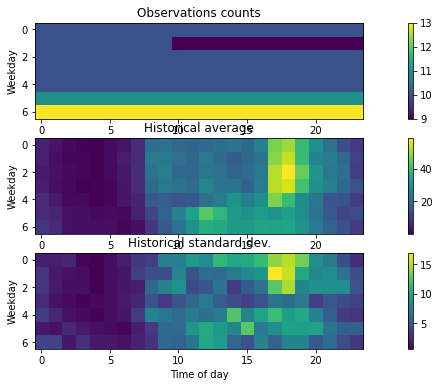

In [4]:
import sys, os
sys.path.append(os.path.abspath("/home/rodr/code/mobility-baselines"))
from mobility_detrender import MobilityDetrender
from evaluation import evaluation
import datetime

detrender1 = MobilityDetrender(day_duration=24, week_duration=7)
trainset_len = N_train # use only trainset for fitting historical averages
detrender1.fit(dataset[:trainset_len,:,0], start_date=datetime.date(2017,7,1), holidays=[3,65])
detrender1.visualize(20)

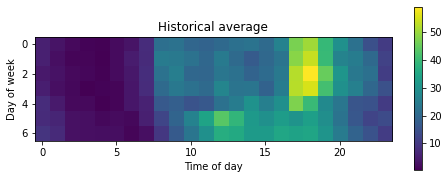

In [7]:
from matplotlib import pyplot as plt
loc = 20
plt.figure(figsize=(8,3))
img = plt.imshow(detrender1.historical_avg[loc,:,:])
plt.title("Historical average")
plt.xlabel("Time of day")
plt.ylabel("Day of week")
plt.colorbar(img)
plt.savefig("3d-dgcn-pickups-HA.pdf")
plt.show()

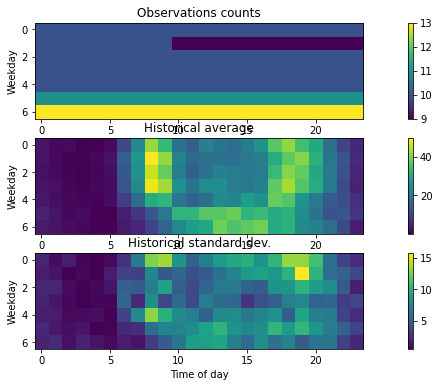

In [9]:
detrender2 = MobilityDetrender(day_duration=24, week_duration=7)
trainset_len = N_train # use only trainset for fitting historical averages
detrender2.fit(dataset[:trainset_len,:,1], start_date=datetime.date(2017,7,1), holidays=[3,65])
detrender2.visualize(20)

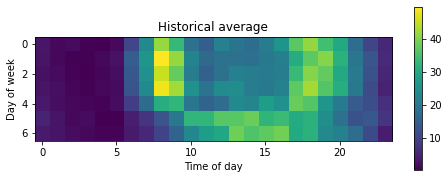

In [11]:
from matplotlib import pyplot as plt
loc = 20
plt.figure(figsize=(8,3))
img = plt.imshow(detrender2.historical_avg[loc,:,:])
plt.title("Historical average")
plt.xlabel("Time of day")
plt.ylabel("Day of week")
plt.colorbar(img)
plt.savefig("3d-dgcn-dropoffs-HA.pdf")
plt.show()

In [6]:
detrended_data1 = detrender1.transform(dataset[:,:,0], start_date=datetime.date(2017,7,1), holidays=[3,65], mode='avg')
detrended_data2 = detrender2.transform(dataset[:,:,1], start_date=datetime.date(2017,7,1), holidays=[3,65], mode='avg')
ha_data = np.concatenate([np.expand_dims(detrender1.ha_trend,-1), 
                          np.expand_dims(detrender2.ha_trend,-1)], axis=-1)
print(ha_data.shape)

evl_train = evaluation(dataset, ha_data)
print('Residuals of Historical Average (on all data) -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_train)) 

(2208, 82, 2)
Residuals of Historical Average (on all data) -> MAPE: 0.444; MAE:  5.686; RMSE: 11.121


In [8]:
# train
x_train = np.zeros((N_train, C, T + 3, num_node), dtype=np.float32)
x_train_ha = np.zeros((N_train, C, T + 3, num_node), dtype=np.float32)
for t in range(N_train):
    x_train[t, :, :, :] = dataset_original[:, t:t + T + 3, :]
    x_train_ha[t, :, :, :] = ha_data[t:t + T + 3, :, :].transpose([2,0,1])
print("x_train.shape:", x_train.shape)
print("x_train_ha.shape:", x_train_ha.shape)

# val
x_val = np.zeros((N_val, C, T + 3, num_node), dtype=np.float32)
x_val_ha = np.zeros((N_val, C, T + 3, num_node), dtype=np.float32)
for t in range(N_train, N_train + N_val):
    x_val[t - N_train, :, :, :] = dataset_original[:, t:t + T + 3, :]
    x_val_ha[t - N_train, :, :, :] = ha_data[t:t + T + 3, :, :].transpose([2,0,1])
print("x_val.shape:", x_val.shape)
print("x_val_ha.shape:", x_val_ha.shape)

# test
x_test = np.zeros((N_test, C, T + 3, num_node), dtype=np.float32)
x_test_ha = np.zeros((N_test, C, T + 3, num_node), dtype=np.float32)
for t in range(N_train + N_val, N_train + N_val + N_test - 2):
    x_test[t - N_train - N_val, :, :, :] = dataset_original[:, t:t + T + 3, :]
    x_test_ha[t - N_train - N_val, :, :, :] = ha_data[t:t + T + 3, :, :].transpose([2,0,1])
print("x_test.shape:", x_test.shape)
print("x_test_ha.shape:", x_test_ha.shape)

x_train.shape: (1762, 2, 8, 82)
x_train_ha.shape: (1762, 2, 8, 82)
x_val.shape: (220, 2, 8, 82)
x_val_ha.shape: (220, 2, 8, 82)
x_test.shape: (220, 2, 8, 82)
x_test_ha.shape: (220, 2, 8, 82)


In [9]:
evl_val = evaluation(x_val[:,:,-1,:], x_val_ha[:,:,-1,:])
print('Validation set -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_val)) 

evl_test = evaluation(x_test[:,:,-1,:], x_test_ha[:,:,-1,:])
print('Test set -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

Validation set -> MAPE: 0.362; MAE:  6.384; RMSE: 11.884
Test set -> MAPE: 0.364; MAE:  5.966; RMSE: 11.037


In [20]:
step_ahead = 1 # num of hours ahead prediction
forecast_ix = step_ahead-3-1
print("forecast_ix:", forecast_ix)

all_preds = []
all_trues = []
for loc in range(x_train.shape[-1]):
    # prepare input data
    x1 = x_train[:,0,:5,loc] - x_train_ha[:,0,:5,loc] # detrend input data for training
    y1 = x_train[:,0,forecast_ix,loc] - x_train_ha[:,0,forecast_ix,loc] # detrend targets for training
    
    # fit ML models
    reg1 = LinearRegression()
    reg1.fit(x1, y1)
    
    # predict on test set
    trues1 = x_test[:,0,forecast_ix,loc] # targets for test set (i.e., actual observations w/o detrending)
    preds1 = reg1.predict(x_test[:,0,:5,loc] - x_test_ha[:,0,:5,loc]) # make predictions on detrended inputs
    preds1 = preds1 + x_test_ha[:,0,forecast_ix,loc] # convert preds back to original scale (revert detrending)
    
    # prepare input data
    x2 = x_train[:,1,:5,loc] - x_train_ha[:,1,:5,loc] # detrend input data for training
    y2 = x_train[:,1,forecast_ix,loc] - x_train_ha[:,1,forecast_ix,loc] # detrend targets for training
    
    # fit ML models
    reg2 = LinearRegression()
    reg2.fit(x2, y2)
    
    # predict on test set
    trues2 = x_test[:,0,forecast_ix,loc] # targets for test set (i.e., actual observations w/o detrending)
    preds2 = reg2.predict(x_test[:,0,:5,loc] - x_test_ha[:,0,:5,loc]) # make predictions on detrended inputs
    preds2 = preds2 + x_test_ha[:,0,forecast_ix,loc] # convert preds back to original scale (revert detrending)
    
    all_preds.append(np.concatenate([preds1[:,np.newaxis],preds2[:,np.newaxis]], axis=-1))
    all_trues.append(np.concatenate([trues1[:,np.newaxis],trues2[:,np.newaxis]], axis=-1))
    
all_preds = np.array(all_preds).T
print(all_preds.shape)
all_trues = np.array(all_trues).T
print(all_trues.shape)

evl_test = evaluation(all_trues, all_preds)
print('Test set -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

forecast_ix: -3
(2, 220, 82)
(2, 220, 82)
Test set -> MAPE: 0.368; MAE:  5.104; RMSE: 8.723


In [19]:
step_ahead = 2 # num of hours ahead prediction
forecast_ix = step_ahead-3-1
print("forecast_ix:", forecast_ix)

all_preds = []
all_trues = []
for loc in range(x_train.shape[-1]):
    # prepare input data
    x1 = x_train[:,0,:5,loc] - x_train_ha[:,0,:5,loc] # detrend input data for training
    y1 = x_train[:,0,forecast_ix,loc] - x_train_ha[:,0,forecast_ix,loc] # detrend targets for training
    
    # fit ML models
    reg1 = LinearRegression()
    reg1.fit(x1, y1)
    
    # predict on test set
    trues1 = x_test[:,0,forecast_ix,loc] # targets for test set (i.e., actual observations w/o detrending)
    preds1 = reg1.predict(x_test[:,0,:5,loc] - x_test_ha[:,0,:5,loc]) # make predictions on detrended inputs
    preds1 = preds1 + x_test_ha[:,0,forecast_ix,loc] # convert preds back to original scale (revert detrending)
    
    # prepare input data
    x2 = x_train[:,1,:5,loc] - x_train_ha[:,1,:5,loc] # detrend input data for training
    y2 = x_train[:,1,forecast_ix,loc] - x_train_ha[:,1,forecast_ix,loc] # detrend targets for training
    
    # fit ML models
    reg2 = LinearRegression()
    reg2.fit(x2, y2)
    
    # predict on test set
    trues2 = x_test[:,0,forecast_ix,loc] # targets for test set (i.e., actual observations w/o detrending)
    preds2 = reg2.predict(x_test[:,0,:5,loc] - x_test_ha[:,0,:5,loc]) # make predictions on detrended inputs
    preds2 = preds2 + x_test_ha[:,0,forecast_ix,loc] # convert preds back to original scale (revert detrending)
    
    all_preds.append(np.concatenate([preds1[:,np.newaxis],preds2[:,np.newaxis]], axis=-1))
    all_trues.append(np.concatenate([trues1[:,np.newaxis],trues2[:,np.newaxis]], axis=-1))
    
all_preds = np.array(all_preds).T
print(all_preds.shape)
all_trues = np.array(all_trues).T
print(all_trues.shape)

evl_test = evaluation(all_trues, all_preds)
print('Test set -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

forecast_ix: -2
(2, 220, 82)
(2, 220, 82)
Test set -> MAPE: 0.381; MAE:  5.449; RMSE: 9.695


In [18]:
step_ahead = 3 # num of hours ahead prediction
forecast_ix = step_ahead-3-1
print("forecast_ix:", forecast_ix)

all_preds = []
all_trues = []
for loc in range(x_train.shape[-1]):
    # prepare input data
    x1 = x_train[:,0,:5,loc] - x_train_ha[:,0,:5,loc] # detrend input data for training
    y1 = x_train[:,0,forecast_ix,loc] - x_train_ha[:,0,forecast_ix,loc] # detrend targets for training
    
    # fit ML models
    reg1 = LinearRegression()
    reg1.fit(x1, y1)
    
    # predict on test set
    trues1 = x_test[:,0,forecast_ix,loc] # targets for test set (i.e., actual observations w/o detrending)
    preds1 = reg1.predict(x_test[:,0,:5,loc] - x_test_ha[:,0,:5,loc]) # make predictions on detrended inputs
    preds1 = preds1 + x_test_ha[:,0,forecast_ix,loc] # convert preds back to original scale (revert detrending)
    
    # prepare input data
    x2 = x_train[:,1,:5,loc] - x_train_ha[:,1,:5,loc] # detrend input data for training
    y2 = x_train[:,1,forecast_ix,loc] - x_train_ha[:,1,forecast_ix,loc] # detrend targets for training
    
    # fit ML models
    reg2 = LinearRegression()
    reg2.fit(x2, y2)
    
    # predict on test set
    trues2 = x_test[:,0,forecast_ix,loc] # targets for test set (i.e., actual observations w/o detrending)
    preds2 = reg2.predict(x_test[:,0,:5,loc] - x_test_ha[:,0,:5,loc]) # make predictions on detrended inputs
    preds2 = preds2 + x_test_ha[:,0,forecast_ix,loc] # convert preds back to original scale (revert detrending)
    
    all_preds.append(np.concatenate([preds1[:,np.newaxis],preds2[:,np.newaxis]], axis=-1))
    all_trues.append(np.concatenate([trues1[:,np.newaxis],trues2[:,np.newaxis]], axis=-1))
    
all_preds = np.array(all_preds).T
print(all_preds.shape)
all_trues = np.array(all_trues).T
print(all_trues.shape)

evl_test = evaluation(all_trues, all_preds)
print('Test set -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

forecast_ix: -1
(2, 220, 82)
(2, 220, 82)
Test set -> MAPE: 0.391; MAE:  5.560; RMSE: 10.044
